
**Group 2:** <span style="color:green">Ellis Hartley, Skylar Millar, Donnie Lawson, Kevin Hunter, Alivia Conway, and Vaia Mavilla</span>

# Project Overview

For this project, we used exploratory data analysis and statistical methods to generate insights for a business stakeholder.

## Business Problem
Computing Vision (a made-up company for the purposes of this project) sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t have much background in creating movies. We were charged with exploring what types of films are currently doing the best at the box office using different samples of available data. We then translated those findings into actionable insights that the head of Computing Vision's new movie studio can use to help decide what type of films to create.

### The Data

In the folder `zippedData` are movie datasets from:

* [Box Office Mojo](https://www.boxofficemojo.com/)
* [IMDB](https://www.imdb.com/)
* [Rotten Tomatoes](https://www.rottentomatoes.com/)
* [TheMovieDB](https://www.themoviedb.org/)
* [The Numbers](https://www.the-numbers.com/)

### Three questions
1. 
2.
3.

### Hypothesis Testing

### Our Findings

### Summary

# Exploratory Analysis

In [1]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from numbers import Number
from math import sqrt
import datetime as dt
%matplotlib inline

### Connecting to and previewing the relevant data

For our purposes we will be using two databases: [The Numbers](https://www.the-numbers.com/) and [IMDB](https://www.imdb.com/).

In [2]:
# import csv with domestic revenue and preview data
revenue_df = pd.read_csv("zippedData/tn.movie_budgets.csv.gz")
revenue_df.head(3)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"


In [3]:
# connect to sqlite database to import data and view genres of movies
conn = sqlite3.connect("zippedData/im.db")
imbd = pd.read_sql('''
SELECT *
FROM movie_basics
''', conn)

# preview data
imbd.head(3)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama


### Initial summary statistics

In [4]:
# view data cleanliness and null values
imbd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


Here we see that our IMBD movie basics table has over 146144 rows of data with around 6000 rows containing null values.

In [5]:
imbd.describe()

,start_year,runtime_minutes
count,146144.000000,114405.000000
mean,2014.621798,86.187247
std,2.733583,166.360590
min,2010.000000,1.000000
25%,2012.000000,70.000000
50%,2015.000000,87.000000
75%,2017.000000,99.000000
max,2115.000000,51420.000000


Here are the summary statistics for our start_year and runtime_minutes columns. Our max start_year is 2115. That can't be right so we will need to address that in the data cleaning portion.

In [6]:
revenue_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


Above we see some information on our The Numbers dataset. It contains 5782 rows with no null values. Our dollar-based columns are recognized as text (or strings in python talk), so we will need to convert those numbers (integers in python talk) for further analysis. 

In [7]:
revenue_df.describe()

,id
count,5782.000000
mean,50.372363
std,28.821076
min,1.000000
25%,25.000000
50%,50.000000
75%,75.000000
max,100.000000


# Data Cleaning
In this section, we'll do the following:
- convert the dollar columns to integers 
- convert our date columns to datetime 
- deal with null values
- remove unrealistic release_dates from The Numbers dataset
- remove unreleastic start_years from the IMBD dataset

### Converting the dollar columns to integers 

In [8]:
# This function takes in a string, removes the dollar sign and commas, 
# and returns an integer (ex: $1,000 --> 1000) 

def clean_dollar(df, column):
    df[column] = df[column].str.strip('$')
    df[column] = df[column].str.replace(',','')
    df[column] = df[column].astype('int64')
    return df[column]

clean_dollar(revenue_df,'production_budget') 
clean_dollar(revenue_df,'domestic_gross')
clean_dollar(revenue_df,'worldwide_gross')

0       2776345279
1       1045663875
2        149762350
3       1403013963
4       1316721747
           ...    
5777             0
5778        240495
5779          1338
5780             0
5781        181041
Name: worldwide_gross, Length: 5782, dtype: int64

In [9]:
# previewing the dataset to observe changes
revenue_df.head(3)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350


### Converting date column to datetime

In [10]:
# converting date column to datetime
revenue_df['release_date'] = pd.to_datetime(revenue_df['release_date'])

# previewing the dataset to observe changes
revenue_df.head(3)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,425000000,760507625,2776345279
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350


### Dealing with null values
Because there are over 140,000 rows in our movie_basics table and only a small percentage are null, we are just going to drop these rows. We are left with 112,232 rows of data, which is more than enough for our analysis.

In [11]:
imbd.dropna(inplace=True)
imbd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112232 entries, 0 to 146139
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         112232 non-null  object 
 1   primary_title    112232 non-null  object 
 2   original_title   112232 non-null  object 
 3   start_year       112232 non-null  int64  
 4   runtime_minutes  112232 non-null  float64
 5   genres           112232 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.0+ MB


### Removing unrealistic release_dates from The Numbers dataset
Our range of release date years from The Numbers is 1915-2020, which seems reasonable. We will filter these years in the next section.

In [12]:
min(revenue_df['release_date'].dt.year), max(revenue_df['release_date'].dt.year)

(1915, 2020)

### Removing unreleastic start_years from the IMBD dataset
Having removed our null values also seems to have fixed our max year problem in the IMBD dataset.

In [13]:
min(imbd['start_year']), max(imbd['start_year'])
# imbd

(2010, 2022)

# Combining and prepping data for analysis
In this section we combine our two datasets on the Title column and filter our data to only include movies released from 2010 that produced above average domestic gross revenue. This filter ensures that our data only contains relevent movies for our recommendations. 

### Combining the Data
Here, we combine the movies from the IMBD dataset and The Numbers dataset on their Primary Titles, i.e. the movie name.

In [14]:
# rename column with movie title to prepare for pandas join
revenue_df.rename(columns={'movie': 'primary_title'}, inplace=True)
revenue_df.head(3)

,id,release_date,primary_title,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,425000000,760507625,2776345279
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350


In [15]:
# create new dataframe including genre, domestic revenue, and  movie title
movies = pd.merge(imbd, revenue_df, on ='primary_title')
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3309 entries, 0 to 3308
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   movie_id           3309 non-null   object        
 1   primary_title      3309 non-null   object        
 2   original_title     3309 non-null   object        
 3   start_year         3309 non-null   int64         
 4   runtime_minutes    3309 non-null   float64       
 5   genres             3309 non-null   object        
 6   id                 3309 non-null   int64         
 7   release_date       3309 non-null   datetime64[ns]
 8   production_budget  3309 non-null   int64         
 9   domestic_gross     3309 non-null   int64         
 10  worldwide_gross    3309 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(4)
memory usage: 310.2+ KB


In [16]:
# create column which contains just one genre instead of a list of genres
movies['main_genre'] = movies["genres"].str.split(',')
movies_df = movies.explode('main_genre')

In [17]:
# dropping duplicates 
movies_df = movies_df.drop_duplicates(subset= ['movie_id'])

In [18]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3133 entries, 0 to 3308
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   movie_id           3133 non-null   object        
 1   primary_title      3133 non-null   object        
 2   original_title     3133 non-null   object        
 3   start_year         3133 non-null   int64         
 4   runtime_minutes    3133 non-null   float64       
 5   genres             3133 non-null   object        
 6   id                 3133 non-null   int64         
 7   release_date       3133 non-null   datetime64[ns]
 8   production_budget  3133 non-null   int64         
 9   domestic_gross     3133 non-null   int64         
 10  worldwide_gross    3133 non-null   int64         
 11  main_genre         3133 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(5), object(5)
memory usage: 318.2+ KB


In [19]:
movies_df.head(3)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,id,release_date,production_budget,domestic_gross,worldwide_gross,main_genre
0,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",26,2012-12-31,45000000,0,73706,Action
1,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",17,2013-03-22,25000000,720828,9313302,Adventure
2,tt2404548,On the Road,On the Road,2011,90.0,Drama,17,2013-03-22,25000000,720828,9313302,Drama


### Filtering the Data
Again, that our filter is:
* Only movies released during or after **2010**
* Only movies where **Domestic Gross Revenue** was **Above Average**

In [20]:
min(movies_df['release_date'].dt.year), max(movies_df['release_date'].dt.year)

(1927, 2019)

In [21]:
min(movies_df['start_year']), max(movies_df['start_year'])

(2010, 2019)

In [22]:
pd.read_sql('''
SELECT *
FROM movie_basics
WHERE primary_title = 'Wings'
''', conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt2284790,Wings,Ot vinta 3D,2012,84.0,"Adventure,Animation,Comedy"
1,tt2406100,Wings,Wings,2012,NaN,Drama
2,tt5872368,Wings,Wings,2014,90.0,Documentary


In [23]:
movies_df[movies_df['primary_title']=='Wings']

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,id,release_date,production_budget,domestic_gross,worldwide_gross,main_genre
2176,tt2284790,Wings,Ot vinta 3D,2012,84.0,"Adventure,Animation,Comedy",85,1927-08-12,2000000,0,0,Adventure
2177,tt5872368,Wings,Wings,2014,90.0,Documentary,85,1927-08-12,2000000,0,0,Documentary


In [24]:
movies_filtered = movies_df[movies_df['start_year'] == movies_df['release_date'].dt.year]
len(movies_filtered)

1500

In [25]:
movies_filtered.head(15)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,id,release_date,production_budget,domestic_gross,worldwide_gross,main_genre
0,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",26,2012-12-31,45000000,0,73706,Action
3,tt3872966,On the Road,On the Road,2013,87.0,Documentary,17,2013-03-22,25000000,720828,9313302,Documentary
7,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",37,2013-12-25,91000000,58236838,187861183,Adventure
8,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",67,2014-09-19,28000000,26017685,62108587,Action
9,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",34,2015-06-12,215000000,652270625,1648854864,Action
10,tt0376136,The Rum Diary,The Rum Diary,2011,119.0,"Comedy,Drama",16,2011-10-28,45000000,13109815,21544732,Comedy
11,tt0383010,The Three Stooges,The Three Stooges,2012,92.0,"Comedy,Family",4,2012-04-13,30000000,44338224,54052249,Comedy
12,tt0393049,Anderson's Cross,Anderson's Cross,2010,98.0,"Comedy,Drama,Romance",65,2010-12-31,300000,0,0,Comedy
13,tt0398286,Tangled,Tangled,2010,100.0,"Adventure,Animation,Comedy",15,2010-11-24,260000000,200821936,586477240,Adventure
14,tt0401729,John Carter,John Carter,2012,132.0,"Action,Adventure,Sci-Fi",14,2012-03-09,275000000,73058679,282778100,Action


In [26]:
print(len(movies_df['primary_title'].unique()))
movies_df.sort_values(by='release_date', ascending=True).head(15)

2203


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,id,release_date,production_budget,domestic_gross,worldwide_gross,main_genre
2177,tt5872368,Wings,Wings,2014,90.0,Documentary,85,1927-08-12,2000000,0,0,Documentary
2176,tt2284790,Wings,Ot vinta 3D,2012,84.0,"Adventure,Animation,Comedy",85,1927-08-12,2000000,0,0,Adventure
3266,tt7821084,Snow White and the Seven Dwarfs,Snow White and the Seven Dwarfs,2017,49.0,"Animation,Family",18,1937-12-21,1488000,184925486,184925486,Animation
3048,tt4828926,Rebecca,Rebecca,2016,85.0,"Drama,Romance",47,1940-03-21,1288000,6000000,6002370,Drama
2782,tt3591950,Fantasia,Fantasia,2014,86.0,Drama,69,1940-11-13,2280000,83320000,83320000,Drama
2460,tt2668120,Bambi,Bambi,2013,58.0,"Biography,Documentary",47,1942-08-13,858000,102797000,268000000,Biography
1442,tt1781058,Wilson,Wilson,2017,94.0,"Comedy,Drama",44,1944-08-01,5200000,2000000,2000000,Comedy
1443,tt7283700,Wilson,Wilson,2017,104.0,Documentary,44,1944-08-01,5200000,2000000,2000000,Documentary
2024,tt2132405,Spellbound,O-ssak-han yeon-ae,2011,114.0,"Comedy,Horror,Romance",74,1945-10-31,1500000,7000000,7000000,Comedy
878,tt1498568,Red River,Red River,2011,77.0,Horror,97,1948-08-26,3000000,9012000,9012000,Horror


# Question 1: What is the best time to release a movie?

### Data exploration

For our question, we only need to use The Numbers dataset. As shown below, this dataset consists of 5782 rows with no Null values. However, our sales and budget columns are categorized as text. We will need to convert these columns to integers. 

In [27]:
revenue_df.head(3)

,id,release_date,primary_title,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,425000000,760507625,2776345279
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350


### Further exploring issues in the dataset

After sorting our dataset, it looks like there are a lot of movies with 0 domestic gross revenue. Below, we explore these issues with revenue further. 

In [31]:
# sorting by domestic gross in ascending order

revenue_df.sort_values(by=['domestic_gross'], ascending=True).head(10)

,id,release_date,primary_title,production_budget,domestic_gross,worldwide_gross
3231,32,2008-12-31,Ca$h,13700000,0,11738256
4762,63,2009-12-31,Chicago Overcoat,3000000,0,0
4763,64,2011-09-13,Never Back Down 2: The Beatdown,3000000,0,0
4764,65,2015-12-31,AWOL-72,3000000,0,0
4194,95,2011-05-10,The Hit List,6000000,0,0
4765,66,2013-01-15,30 Nights Of Paranormal Activity With The Devi...,3000000,0,0
4766,67,2015-02-06,Enter the Dangerous Mind,3000000,0,0
5207,8,2013-12-31,The Vatican Exorcisms,1100000,0,0
5206,7,2010-12-31,The Dead Undead,1100000,0,0
5205,6,2015-04-07,Silent Running,1100000,0,0


Below we see there are 548 rows of data where domestic gross revenue is equal to 0.

In [32]:
df_zeros = revenue_df[revenue_df['domestic_gross']==0]
print(len(df_zeros))
df_zeros

548


,id,release_date,primary_title,production_budget,domestic_gross,worldwide_gross
194,95,2020-12-31,Moonfall,150000000,0,0
479,80,2017-12-13,Bright,90000000,0,0
480,81,2019-12-31,Army of the Dead,90000000,0,0
535,36,2020-02-21,Call of the Wild,82000000,0,0
617,18,2012-12-31,AstÃ©rix et ObÃ©lix: Au service de Sa MajestÃ©,77600000,0,60680125
...,...,...,...,...,...,...
5761,62,2014-12-31,Stories of Our Lives,15000,0,0
5764,65,2007-12-31,Tin Can Man,12000,0,0
5771,72,2015-05-19,Family Motocross,10000,0,0
5777,78,2018-12-31,Red 11,7000,0,0


Something else is going on here since these revenues are too low. A quick google search on "Ed and his Dead Mother" shows a few well-known actors so these numbers are probably incorrect. Again, this shouldn't be an issue if we filter out all below average revenue movies.

In [33]:
# dropping rows where domestic gross is zero

df = revenue_df.drop(revenue_df[revenue_df['domestic_gross']==0].index)

df.sort_values(by=['domestic_gross'], ascending=True).head(10)

,id,release_date,primary_title,production_budget,domestic_gross,worldwide_gross
3731,32,2014-12-26,Barbecue,10000000,388,247565
5770,71,2008-08-14,The Rise and Fall of Miss Thang,10000,401,401
5518,19,2005-10-13,The Dark Hours,400000,423,423
5769,70,1996-04-01,Bang,10000,527,527
5466,67,2018-05-11,Higher Power,500000,528,528
5027,28,1993-01-01,Ed and his Dead Mother,1800000,673,673
5298,99,2002-12-13,The Jimmy Show,1000000,703,703
4422,23,2007-10-19,Out of the Blue,4600000,728,731767
4081,82,2010-05-21,Perrierâs Bounty,6600000,828,828
5297,98,2006-04-21,In Her Line of Fire,1000000,884,884


### Filtering our data for above average revenue and 2010 and up

Since we are only interested in successful movies, we are going to filter our dataset to only include "above average" movies. Also, since the movie industry has changed over the years, we are only going to include movies that were created during or after 2010. 

In [34]:
average_dom_gross = df['domestic_gross'].mean()
print(average_dom_gross)
cutoff_year = 2010

46257465.79002675


In [35]:
df_filtered = df[(df['domestic_gross'] > average_dom_gross) & (df['release_date'].dt.year >= cutoff_year)]
df_filtered

,id,release_date,primary_title,production_budget,domestic_gross,worldwide_gross
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747
5,6,2015-12-18,Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220
6,7,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200
...,...,...,...,...,...,...
4666,67,2013-06-07,The Purge,3000000,64473115,91266581
4668,69,2012-10-12,Sinister,3000000,48086903,87727807
5062,63,2011-04-01,Insidious,1500000,54009150,99870886
5189,90,2014-03-21,Godâs Not Dead,1150000,60755732,63777092


We have 614 movies in our dataset. At this point, we are ready for our analysis.

# Data Analysis

In this section, we plot out the following:

- Count of movies by season
- Total revenue by season
- Average revenue by season

### Creating the 'seasons' column 

In [36]:
# Create a new row called 'seasons' that categorizes the dates columns by season. Seasons are as follows:

# summer = june 21 - sept 22 (06/21-09/22) --> summer months = 6,7,8
# fall = sept 23 - dec 20 (09/23-12/20) --> fall months = 9,10,11
# winter = dec 21 - mar 18 (12/21-03/18) --> winter months = 12,1,2
# spring = mar 19 - jun 20 (03/19-06/20) --> spring months = 3,4,5

summer = [6, 7, 8]
fall = [9, 10, 11]
winter = [12, 1, 2]
spring = [3, 4, 5]

def f(row):
    if row['release_date'].month in summer:
        val = 'Summer'
    elif row['release_date'].month in fall:
        val = 'Fall'
    elif row['release_date'].month in winter:
        val = 'Winter'
    else:
        val = 'Spring'
    return val

df_filtered['seasons'] = df_filtered.apply(f, axis=1)

<ipython-input-36-7708eb4f38b1>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['seasons'] = df_filtered.apply(f, axis=1)


In [59]:
df_filtered.head(5)

,id,release_date,primary_title,production_budget,domestic_gross,worldwide_gross,seasons,month_name,month,net_revenue
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,Spring,May,5,635063875
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,Spring,May,5,1072413963
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,Winter,Dec,12,999721747
5,6,2015-12-18,Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,Winter,Dec,12,1747311220
6,7,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,Spring,Apr,4,1748134200


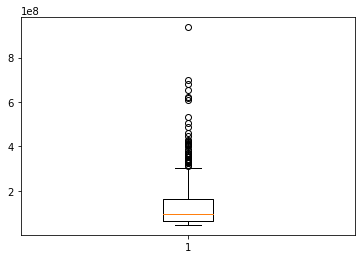

In [39]:
# a boxplot of our domestic gross column

plt.boxplot(df_filtered['domestic_gross'])
plt.show()

This boxplot tells us that the distribution of our domestic gross column has a lot of outliers. Each of the circle dots represents an outlier.

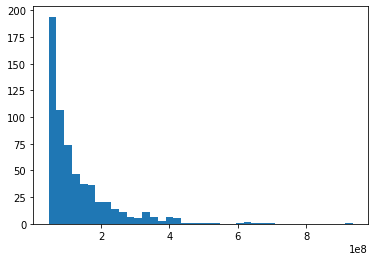

In [40]:
# a histogram of our domestic gross column

plt.hist(df_filtered['domestic_gross'], bins='auto')
plt.show()

This histogram tells us that the distribution of our domestic gross column is non-normal.

In [41]:
df_filtered['domestic_gross'].median()

93526665.5

This is a non-normal distribution that is highly skewed. 

<AxesSubplot:xlabel='seasons'>

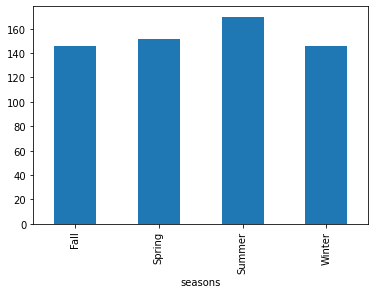

In [42]:
# plotting count of movies by season
   
tdf_filtered.groupby('seasons')['primary_title'].count().plot(kind='bar')

This plot show that the majority of movies are produced in the summer.

<AxesSubplot:xlabel='seasons'>

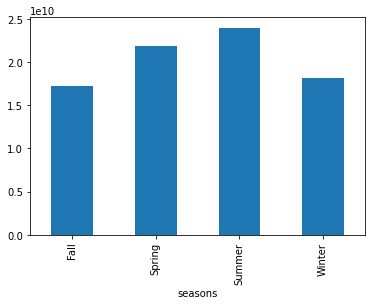

In [43]:
# plotting sum of gross revenue generated from movies by season

df_filtered.groupby('seasons')['domestic_gross'].sum().plot(kind='bar')

As would be expected, the summer months have the highest sum of gross domestic revenue.

In [44]:
df_means = df_filtered.groupby('seasons')['domestic_gross'].mean().reset_index()
df_means

,seasons,domestic_gross
0,Fall,1.178734e+08
1,Spring,1.434735e+08
2,Summer,1.410806e+08
3,Winter,1.244989e+08


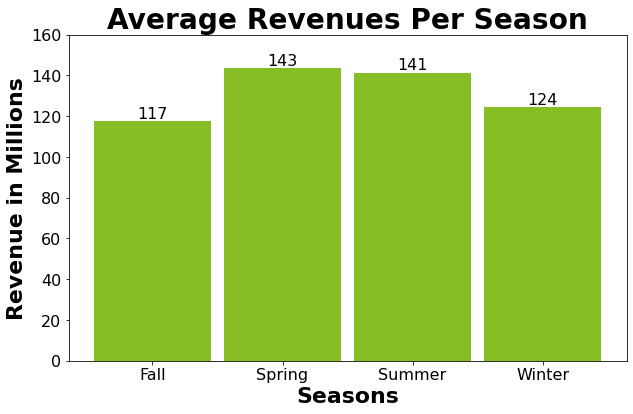

In [61]:
# plotting average of gross revenue generated from movies by season
seasons = df_means['seasons']
rev_per_mil = df_means['domestic_gross']/1000000

# sns.set_style('dark')

plt.figure(figsize=(10,6))

barlist = plt.bar(seasons, rev_per_mil, width=0.9, color = '#86BC24')
# barlist[2].set_color('#86BC24')
plt.title('Average Revenues Per Season', fontsize=28, fontweight='bold')
plt.xlabel("Seasons", fontsize=22, fontweight='bold')
plt.ylabel("Revenue in Millions", fontsize=22, fontweight='bold')
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylim(top=160)

# placing the mean value of each season above its corresponding bar.
for index, value in enumerate(rev_per_mil.astype(int)):
    plt.text(index,value+2, str(value), fontsize=16, horizontalalignment='center')

plt.show()    


Our plot seems to somewhat agree with our hypothesis. If we wanted to further test our hypothesis, we could perform a chi-squared test, as shown below. 


In [46]:
summer_df = df_filtered[df_filtered['seasons']=='Summer']
print(f"mean: {summer_df['domestic_gross'].mean().astype(int)}; number of movies: {len(summer_df)}")

mean: 141080559; number of movies: 170


In [47]:
summer_df.head()

,id,release_date,primary_title,production_budget,domestic_gross,worldwide_gross,seasons
10,11,2012-07-20,The Dark Knight Rises,275000000,448139099,1084439099,Summer
12,13,2013-07-02,The Lone Ranger,275000000,89302115,260002115,Summer
28,29,2013-06-14,Man of Steel,225000000,291045518,667999518,Summer
30,31,2012-07-03,The Amazing Spider-Man,220000000,262030663,757890267,Summer
32,33,2017-06-21,Transformers: The Last Knight,217000000,130168683,602893340,Summer


In [48]:
# Population mean
mu_0 = df_filtered['domestic_gross'].mean()

# Population standard deviation
sigma = df_filtered['domestic_gross'].std()

# Mean gross revenue of summer sample
x_bar = summer_df['domestic_gross'].mean()

# std gross revenue of summer sample
x_std = summer_df['domestic_gross'].std()

# Number of movies in the whole population
n = len(df_filtered)

# Number of movies in the sample
n_sample = len(summer_df)

# Alpha (1 - confidence level)
alpha = 0.05

### Further analysis based on months and comparing gross revenue to net revenue
We wanted to drill down on our data and break revenue down by the month to see what month would be the most optimal to release a movie.  

In [49]:
df_filtered['month_name'] = df_filtered['release_date'].dt.strftime('%b')
df_filtered['month'] = df_filtered['release_date'].dt.month

df_filtered

<ipython-input-49-b0d64b85b55c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['month_name'] = df_filtered['release_date'].dt.strftime('%b')
<ipython-input-49-b0d64b85b55c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['month'] = df_filtered['release_date'].dt.month


,id,release_date,primary_title,production_budget,domestic_gross,worldwide_gross,seasons,month_name,month
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,Spring,May,5
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,Spring,May,5
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,Winter,Dec,12
5,6,2015-12-18,Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,Winter,Dec,12
6,7,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,Spring,Apr,4
...,...,...,...,...,...,...,...,...,...
4666,67,2013-06-07,The Purge,3000000,64473115,91266581,Summer,Jun,6
4668,69,2012-10-12,Sinister,3000000,48086903,87727807,Fall,Oct,10
5062,63,2011-04-01,Insidious,1500000,54009150,99870886,Spring,Apr,4
5189,90,2014-03-21,Godâs Not Dead,1150000,60755732,63777092,Spring,Mar,3


In [50]:
df_filtered['net_revenue'] = df_filtered['worldwide_gross'].astype(int) - df_filtered['production_budget']
df_filtered

<ipython-input-50-7f45004f86ed>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['net_revenue'] = df_filtered['worldwide_gross'].astype(int) - df_filtered['production_budget']


,id,release_date,primary_title,production_budget,domestic_gross,worldwide_gross,seasons,month_name,month,net_revenue
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,Spring,May,5,635063875
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,Spring,May,5,1072413963
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,Winter,Dec,12,999721747
5,6,2015-12-18,Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,Winter,Dec,12,1747311220
6,7,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,Spring,Apr,4,1748134200
...,...,...,...,...,...,...,...,...,...,...
4666,67,2013-06-07,The Purge,3000000,64473115,91266581,Summer,Jun,6,88266581
4668,69,2012-10-12,Sinister,3000000,48086903,87727807,Fall,Oct,10,84727807
5062,63,2011-04-01,Insidious,1500000,54009150,99870886,Spring,Apr,4,98370886
5189,90,2014-03-21,Godâs Not Dead,1150000,60755732,63777092,Spring,Mar,3,62627092


<AxesSubplot:xlabel='month'>

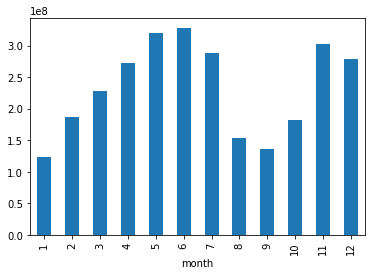

In [51]:
df_filtered.groupby('month')['net_revenue'].mean().plot(kind='bar')

In [62]:
# creating our 
month = ['Jan', 'Feb', 'Mar', 'Apr',
          'May', 'Jun', 'Jul', 'Aug',
          'Sep', 'Oct', 'Nov', 'Dec']


month_means = df_filtered.groupby('month')['domestic_gross'].mean().reset_index()

months = month_means['month']
rev_per_mth = month_means['domestic_gross']/1000000

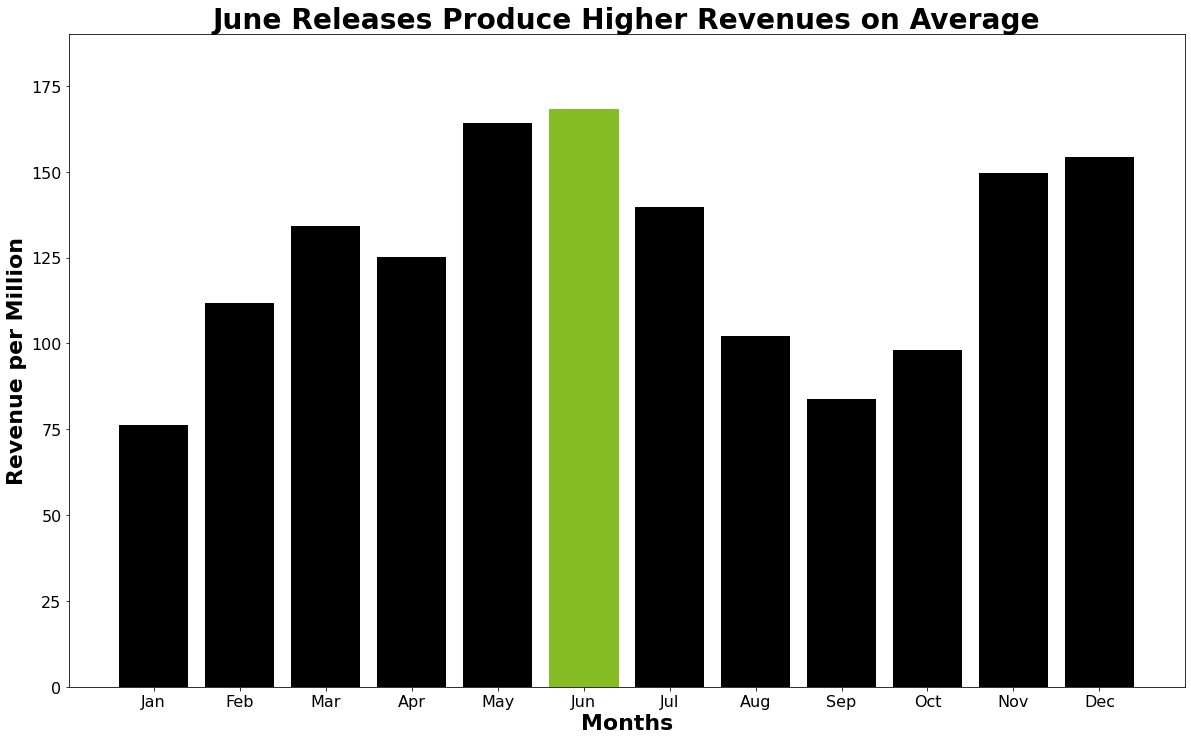

In [54]:
plt.figure(figsize=(20,12))

barlist = plt.bar(months, rev_per_mth, color = 'black')
barlist[5].set_color('#86BC24')
plt.title('June Releases Produce Higher Revenues on Average', fontsize=28, fontweight='bold')
plt.xlabel("Months", fontsize=22, fontweight='bold')
plt.ylabel("Revenue per Million", fontsize=22, fontweight='bold')
plt.xticks(ticks=months,labels=month,fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylim(top=190)


# for index, value in enumerate(rev_per_mth.astype(int)):
#     plt.text(index,value, str(value), fontsize=16)

plt.show()    

# Question 2: What is the best duration for a movie to optimize revenue?

# Length of Movie in Relation to Movie Earnings

### Importing the libraries and data provided to start visualizing and previewing the data that will be used in the analysis.

In [55]:
# Previewing The Numbers data
revenue_df.head()

,id,release_date,primary_title,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,425000000,760507625,2776345279
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747


### Taking a preview of the data that was imported so we can search for any missing values. This data will be joined with the SQL database im.db later so we can run queries more accurately.

In [56]:
#looking for missing data, rows and column information
revenue_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   primary_title      5782 non-null   object        
 3   production_budget  5782 non-null   int64         
 4   domestic_gross     5782 non-null   int64         
 5   worldwide_gross    5782 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 271.2+ KB


### Now that we saw a preview of the data, we needed to create a function which would help clean the domestic_gross column in our dataset in order to be used for statistical calculations later.

In [57]:
#Changing the domestic_gross values to an integer and removing $ and commas using a function
def clean_dollar(df, column):
    df[column] = df[column].str.strip('$')
    df[column] = df[column].str.replace(',','')
    df[column] = df[column].astype(int)
    return df[column]

In [58]:
#Applying function to columns and previewing data
clean_dollar(revenue_df,'domestic_gross')
revenue_df.head()

AttributeError: Can only use .str accessor with string values!

# Slicing out columns that will be used for our analysis.

In [ ]:
#Only selecting movie, and domestic_gross columns 
gross = revenue_df.iloc[:, [2, 4]]
gross

We decided to find the average domestic gross to verify what is considered above average and a successful movie. 

In [ ]:
#Finding the mean/avg of the gross revenue
avgg = gross['domestic_gross'].mean()
avgg

# Importing SQL Database

In [ ]:
#connecting to the sql database to import runtime minutes
con = sqlite3.connect('zippedData/im.db')
#Assigning a variable to sql query for runtime minutes
runtime = pd.read_sql("""
SELECT *
FROM movie_basics
""", con)
runtime.info() #Checking for null values and discrepancies

### Ran a query to see that only 132 out of 114K movies were over 300 minutes long. Justifying the filter for 300 minutes.

In [ ]:
runtime = pd.read_sql("""
SELECT COUNT(runtime_minutes) as high_run
FROM movie_basics
WHERE runtime_minutes is not null and runtime_minutes >= 300
order by runtime_minutes desc
""", con)
runtime

In [ ]:
#Updating runtime to only show runtimes under 5 hours
runtime = pd.read_sql("""
SELECT runtime_minutes
FROM movie_basics
WHERE runtime_minutes is not null AND runtime_minutes < 300
""", con)
run = runtime.astype(int) #Changing runtimes to integers
run.describe() #Getting statistical data on runtimes to determine avg movie length

In [ ]:
#Importing movie_gross data into sql database for querying
gross.to_sql("movie_gross", con, if_exists="replace")

## Join together new movie_gross table with movie_basics to run a query and compare movie earnings with runtimes

In [ ]:
filtered_gross = pd.read_sql("""
SELECT DISTINCT domestic_gross, runtime_minutes
FROM movie_gross
LEFT JOIN movie_basics
ON movie_gross.movie = movie_basics.primary_title
WHERE runtime_minutes is not null and runtime_minutes BETWEEN 30 AND 300 AND domestic_gross > 41873326
ORDER BY domestic_gross DESC
LIMIT 1000
""", con).drop_duplicates()
filtered_gross = filtered_gross.astype(int)
filtered_gross
#filtering out movies that made less than the average gross of 40 million and had runtimes between 30 minutes and 5 hours
#only showing movies that earned above the average domestic gross of 41873326

# Visualizations for the Analysis

In [ ]:
#Histogram showing runtime minutes for movies that earned above average revenue
sns.displot(filtered_gross['runtime_minutes'], bins='auto', kde=True)

In [ ]:
#Scatter plot visualization comparing revenue to movie length
filtered_gross.plot.scatter(x = 'runtime_minutes',y= 'domestic_gross',s = 10, c = '#86BC24', figsize=(13,7), alpha = 0.5)
plt.xlabel('Runtime', fontsize = 14, fontweight = 'bold')
plt.ylabel('Movie Gross', fontsize = 14, fontweight = 'bold')
plt.title('Movie Earnings in Relation to Movie Runtime', fontsize = 22, fontweight = 'bold')

In [ ]:
#
plt.figure(figsize=(12, 7))

plt.bar(filtered_gross['runtime_minutes'], filtered_gross['domestic_gross'], color = '#86BC24', edgecolor = 'none')
plt.title('Movie Gross Compared to Runtime', fontsize = 20, fontweight = 'bold')
plt.xlabel('Runtime', fontweight= 'bold', fontsize = 14)
plt.ylabel('Movie Gross', fontweight = 'bold', fontsize = 14)
plt.show()

In [ ]:
minutes = [30, 60, 90, 120, 150, 180]
bin1 = range(30, 60)
bin2 = range(61, 90)
bin3 = range(91, 120)
bin4 = range(121, 150)
def f(row):
    if row['runtime_minutes'] in bin1:
        val = 'A'
    elif row['runtime_minutes'] in bin2:
        val = 'B'
    elif row['runtime_minutes'] in bin3:
        val = 'C'
    elif row['runtime_minutes'] in bin4:
        val = 'D'
    else:
        val = 'E'
    return val
filtered_gross['runtime_minutes_grouped'] = filtered_gross.apply(f, axis=1)
filtered_gross.head(25)

In [ ]:
df_run = filtered_gross.groupby('runtime_minutes_grouped')['domestic_gross'].mean().reset_index()
df_run

In [ ]:
df_ordered = df_run.sort_values(['runtime_minutes_grouped','domestic_gross'], ascending=True)
df_ordered

# Visualization Chart Analysis
We created a bar chart to help show the movie runtimes in comparison to the domestic gross for each movie in 30 minute increments to help show the relationship.

In [ ]:
import matplotlib.patches as mpatches
plt.figure(figsize = (12, 7)) #adjusting the figure size of the bar graph
#Plotting a bar chart and dividing the domestic gross column by 1 million to have the y axis increments clearly defined
plt.bar(df_ordered['runtime_minutes_grouped'],df_ordered['domestic_gross']/1000000,align='center', edgecolor='black', color = '#86BC24')
plt.title('Movies That Run Longer Generate More Earnings', fontsize = 22, fontweight = 'bold') #plotting the title
plt.ylabel('Movie Earnings by Millions', fontsize = '14', fontweight = 'bold') #plotting the y axis label
plt.xlabel('Runtime by Increments of 30 minutes', fontsize = '14', fontweight = 'bold') #plotting the x axis label


patch1 = mpatches.Patch(color = '#86BC24', label= 'A = 30-60 Min')
patch2 = mpatches.Patch(color = '#86BC24', label = 'B = 61-90 Min')
patch3 = mpatches.Patch(color = '#86BC24', label = 'C = 91-120 Min')
patch4 = mpatches.Patch(color = '#86BC24', label = 'D = 121-150 Min')
patch5 = mpatches.Patch(color = '#86BC24', label = 'E = 151-180 Min')
plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], fontsize = 14)

Based off of the above analysis and visualizations, we suggest making movies between 121 and 150 minutes in length to maximize profits. Taking into account the top 990 grossing movies that are between 30 minutes and 300 minutes in length.

# Question 3: What is the best genre for optimal revenue?

### Exploring the Relationship Between Movie Genres and Gross Domestic Revenue

For our first business insight, we will be researching and exploring how genre affects domestic revenue. This is relevant as very costly resources are allocated to creating movies and it is important to understand what genres perform the best prior to making a decision as to what kind of movies Computing Vision will make. Let's start by taking a look at our movie data.

<img src="https://i0.wp.com/news.northeastern.edu/wp-content/uploads/2022/05/movie_theater_1400.jpg?w=1400&ssl=1" width=500>

Image Source: https://news.northeastern.edu/2022/05/26/movie-theater-hearing-damage/

By Alivia and Vaia

In [ ]:
# sort data frame to ensure that the visualization is in order
sorted_movies_df = movies_filtered.sort_values(['main_genre','domestic_gross'], ascending=True)
sorted_movies_df.head()

In [ ]:
total_action = sorted_movies_df[(sorted_movies_df['main_genre'] == 'Horror')]
max(total_action['domestic_gross'])

In [ ]:
# plot genre in relation to revenue - this visualization excludes outliers

plt.figure(figsize=(20,12))

plt.bar(sorted_movies_df['main_genre'], sorted_movies_df["domestic_gross"], width=0.9, bottom=0.2, color='#86BC24')

plt.xlabel('Genres', fontsize=22, fontweight='bold')
plt.ylabel('Domestic Revenue', fontsize = 22, fontweight='bold')
plt.xticks(rotation='45', fontsize = 16)


plt.title('Highest Revenue Movie by Genre - Hundreds of Millions', fontsize = 28, fontweight='bold')


plt.show()


# Visualization Analysis: Bar Plot
According to our bar plot, the genres with the greatest performing movies in terms of gross domestic revenue are of the horror, action, family, and adventure genres. It is to be noted that often times action, family, and adventure movies are typically marketed towards and consumed by a wider group of people due to age appropriate ratings as opposed to horror, which is often times rated PG-13 or R and cannot be seen by a large group of people. This notion will guide our hypothesis test that is later to come.

In [ ]:
sns.catplot(data=movies_df, x="domestic_gross", y="main_genre", kind="box", color='#86BC24')

# Visualization Analysis: Box Plot
According to our boxplot, we can see several outliers beyond the cohorts exist in the action and adventure categories, meaning these genres have several movies that performed extremely well compared to other movies. Note that horror films have less outliers than the other genres as well as smaller measures of central tendency than animation, adventure, action, and musical genres. Let's see what those top grossing movies are called.

In [ ]:
top_action = movies_df[(movies_df['main_genre'] == 'Action') & (movies_df['domestic_gross'] > 600000000)]
top_action

### Superheroes
All but one of our top 5 action movies are about superheroes, two were a part of the same saga, Avengers, and two of them are sequels to very successful movies. This says a lot about the cinema audience. What about our greatest value, the horror film as shown in the box plot?

In [ ]:
top_horror = movies_df[(movies_df['main_genre'] == 'Horror') & (movies_df['domestic_gross'] > 600000000)]
top_horror

The top grossing movie of this entire dataset is Avatar at over $2.7 billion! Classified as a horror movie in our dataset, it is considered to be a dystopian action movie. 

In [ ]:
cp = sns.catplot(data=movies_df, x="domestic_gross", y="main_genre", color='#86BC24')

# Visualization Analysis: Categorical Plot
Our categorical plot differs from the previous two graphs, depicting action as the most successful movie genre in terms of gross domestic revenue, followed by adventure, and the horror genre looks like it pulls in much less.


# Hypothesis Test: Best Movie Genre?
We hypothesize that the movies which are classified as action have a higher gross revenue than other genres as it is typically a more family-friendly genre. 

## Null: Action movies have a lower or equal average gross domestic revenue than the rest of movies 


## Alternative: Action movies have a significantly greater gross domestic revenue than the rest of movies

We will be conducting a one sample z-test at the alpha level of 0.05 to compare the mean gross revenue of action movies versus the mean gross revenue of all movies, to see if this genre sticks out as more successful than others. 

In [ ]:
a = 0.05
a

In [ ]:
mu = movies_df['domestic_gross'].mean() # population mean
mu

In [ ]:
sigma = movies_df['domestic_gross'].std() # population standard deviation
sigma

In [ ]:
n = len(movies_df[movies_df['main_genre'] == 'Action']) # sample size
n

In [ ]:
# query domestic gross for just action movies and store it into variable to calculate 'sample' mean
sample_action = movies_df.query("main_genre == 'Action'")['domestic_gross']
sample_action

In [ ]:
x_bar = sample_action.mean() # sample mean
x_bar

In [ ]:
# calculcate the test statistic
z = (x_bar - mu)/(sigma/sqrt(n))
z

In [ ]:
# calculate the p-value
p = 1 - stats.norm.cdf(z)
p

In [ ]:
# interpret our p-value in terms of our alpha level 
# Is there is a statistically significant difference?
# Can we reject the null hypothesis?
p < a

Our p-value is less than the alpha so we must reject the null hypothesis!

## Hypothesis Test Results 
### We reject the null and conclude that action movies have a significantly greater gross domestic revenue than the rest of movies!

Taking this into consideration, we make the suggestion that the studio should focus on creating action movies in order to maximize revenue.

<img src="https://assets.simpleviewinc.com/simpleview/image/upload/c_fill,h_805,q_50,w_1903/v1/clients/eauclaire-redesign/2da0fb8c_23a4_430a_b852_abb92a27f8b0_1d053ad0-78ed-4dc2-8fb2-47f6160893e8.jpg" width=500>

Image Source: https://www.visiteauclaire.com/things-to-do/arts/cinemas/

# Conclusion

# Further analysis

In [ ]:
# Box office movies dataset

df_bom = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
df_bom.head(1)

In [ ]:
# TheMovieDB dataset

df_tmbd = pd.read_csv('zippedData/tmdb.movies.csv.gz')
df_tmbd.head(1)

In [ ]:
# The Numbers dataset

revenue_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
revenue_df.head(1)

In [ ]:
# Rotten Tomatoes movie info dataset

df_rt_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t')
df_rt_info.head(1)

In [ ]:
# Rotten Tomatoes movie reviews dataset

df_rt_reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t', encoding='ansi')
df_rt_reviews.head(1)

In [ ]:
pd.read_sql('''
SELECT mb.start_year, mb.runtime_minutes, mb.genres, mr.averagerating, mr.numvotes
FROM movie_basics mb
JOIN movie_ratings mr
USING(movie_id)

''', conn).head()